In [1]:
import pyart
from matplotlib import pyplot as plt
import cartopy
from boto.s3.connection import S3Connection
import datetime
import tempfile
import numpy as np
import xarray
import netCDF4 
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
import cartopy.crs as ccrs
import cartopy.io.img_tiles as cimgt
import pytz

%matplotlib inline


## You are using the Python ARM Radar Toolkit (Py-ART), an open source
## library for working with weather radar data. Py-ART is partly
## supported by the U.S. Department of Energy as part of the Atmospheric
## Radiation Measurement (ARM) Climate Research Facility, an Office of
## Science user facility.
##
## If you use this software to prepare a publication, please cite:
##
##     JJ Helmus and SM Collis, JORS 2016, doi: 10.5334/jors.119



/Users/scollis/anaconda/envs/pypower/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
def _nearestDate(dates, pivot):
    return min(dates, key=lambda x: abs(x - pivot))


def get_radar_from_aws(site, datetime_t):
    """
    Get the closest volume of NEXRAD data to a particular datetime.
    Parameters
    ----------
    site : string
        four letter radar designation
    datetime_t : datetime
        desired date time
    Returns
    -------
    radar : Py-ART Radar Object
        Radar closest to the queried datetime
    """

    # First create the query string for the bucket knowing
    # how NOAA and AWS store the data
    my_pref = datetime_t.strftime('%Y/%m/%d/') + site

    # Connect to the bucket
    conn = S3Connection(anon = True)
    bucket = conn.get_bucket('noaa-nexrad-level2')

    # Get a list of files
    bucket_list = list(bucket.list(prefix = my_pref))

    # we are going to create a list of keys and datetimes to allow easy searching
    keys = []
    datetimes = []

    # populate the list
    for i in range(len(bucket_list)):
        this_str = str(bucket_list[i].key)
        if 'gz' in this_str:
            endme = this_str[-22:-4]
            fmt = '%Y%m%d_%H%M%S_V0'
            dt = datetime_t.strptime(endme, fmt)
            datetimes.append(dt)
            keys.append(bucket_list[i])

        if this_str[-3::] == 'V06':
            endme = this_str[-19::]
            fmt = '%Y%m%d_%H%M%S_V06'
            dt = datetime_t.strptime(endme, fmt)
            datetimes.append(dt)
            keys.append(bucket_list[i])

    # find the closest available radar to your datetime
    closest_datetime = _nearestDate(datetimes, datetime_t)
    index = datetimes.index(closest_datetime)

    localfile = tempfile.NamedTemporaryFile()
    print(keys[index])
    keys[index].get_contents_to_filename(localfile.name)
    radar = pyart.io.read(localfile.name)
    return radar

In [16]:
def grids_to_x(grids):
    long, lat = grids.get_point_longitude_latitude()
    height = grids.point_z['data'][:,0,0]
    time = np.array([ netCDF4.num2date(grids.time['data'][0], grids.time['units'])])
    ds = xarray.Dataset()
    for this_field in list(grids.fields.keys()):
        this_data = grids.fields[this_field]['data']
        my_data = xarray.DataArray(np.ma.expand_dims(this_data,0),
                                   dims = ('time', 'z', 'y', 'x'),
                                   coords = {'time' : (['time'], time),
                                             'z' : (['z'], height),
                                             'lat' :(['y','x'], lat),
                                             'lon' : (['y','x'],long),
                                              'y' : (['y'],lat[:,0]),
                                              'x' : (['x'],long[0,:])})

        for this_meta in list(grids.fields[this_field].keys()):
            if this_meta is not 'data':
                my_data.attrs.update({this_meta: grids.fields[this_field][this_meta]})

        ds[this_field] = my_data
        ds.lon.attrs = [('long_name', 'longitude of grid cell center'),
                 ('units', 'degrees_east')]
        ds.lat.attrs = [('long_name', 'latitude of grid cell center'),
                 ('units', 'degrees_north')]
        ds.z.attrs['long_name'] = "height above sea sea level"
        ds.z.attrs['units'] = "m"

        ds.z.encoding['_FillValue'] = None
        ds.lat.encoding['_FillValue'] = None
        ds.lon.encoding['_FillValue'] = None
    return ds

In [19]:
def make_radar_grid(date_desired, site, tz = None, gridspec = None):
    if tz is None:
        tz = 'US/Eastern'
    
    if gridspec is None:
        gridspec = {}
        gridspec['size'] = (1,801,801)
        gridspec['domain'] = ((1000.,1001.),(-200000.,200000.),(-200000.,200000.))
    
    radar = get_radar_from_aws(site, date_desired)
    flds = radar.fields.keys()
    sweep = 0
    index_at_start = radar.sweep_start_ray_index['data'][sweep]
    time_at_start_of_radar = netCDF4.num2date(radar.time['data'][index_at_start], 
                                      radar.time['units'])
    eastern = pytz.timezone(tz)
    local_time = eastern.fromutc(time_at_start_of_radar)
    fancy_date_string = local_time.strftime('%A %B %d at %I:%M %p %Z')
    speckles_radar = pyart.correct.despeckle.despeckle_field(radar, 'reflectivity')
    grids = pyart.map.grid_from_radars((radar,), gridspec['size'],
                       gridspec['domain'],
                       fields=flds,
                       refl_field='reflectivity', 
                       gatefilters=(speckles_radar, )) 
    
    xar = grids_to_x(grids)
    return xar
    

In [122]:
dt = datetime.datetime(2012,10,29,0,0)
this_ds = make_radar_grid(dt, 'KDIX')

<Key: noaa-nexrad-level2,2012/10/29/KDIX/KDIX20121029_000319_V06.gz>


/Users/scollis/anaconda/envs/pypower/lib/python3.6/site-packages/xarray/core/dtypes.py:23: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if np.issubdtype(dtype, float):


/Users/scollis/anaconda/envs/pypower/lib/python3.6/site-packages/xarray/core/dtypes.py:23: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if np.issubdtype(dtype, float):


Text(0.5,1,'Sunday October 28 at 08:03 PM EDT')

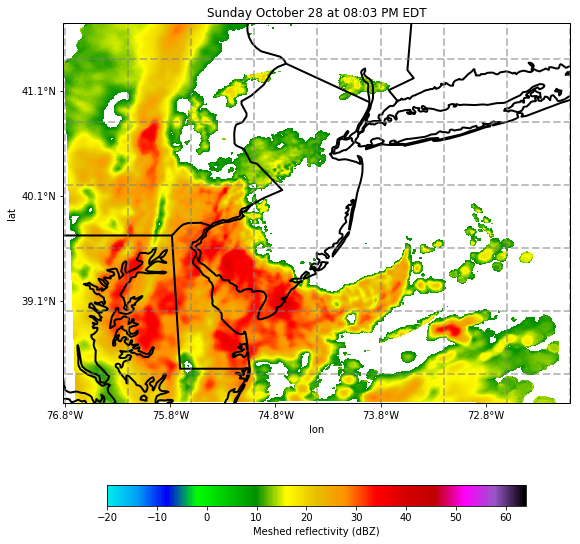

In [123]:
lat_lines = np.arange(np.around(this_ds.lat.min(), decimals=1), 
                      this_ds.lat.max(), 1)
lon_lines = np.arange(np.around(this_ds.lon.min(),decimals=1),
                      this_ds.lon.max(), 1)

fig = plt.figure(figsize=[15,10])

my_ax = plt.subplot(projection = ccrs.PlateCarree())

z_var = this_ds.reflectivity[0].sel(z=1000, method='nearest')
pc = z_var.where(z_var > 10).plot.pcolormesh(transform=ccrs.PlateCarree(), ax=my_ax,
                                                x='lon', y='lat', vmin=-20,
                                                    vmax=64, cmap=pyart.graph.cm.NWSRef,
                                                add_colorbar=False)

cb1 = plt.colorbar(mappable=pc, orientation='horizontal', shrink = 0.5)
cb1.set_label('Meshed reflectivity (dBZ)')

my_ax.set_xticks(lon_lines, crs=ccrs.PlateCarree())
my_ax.set_yticks(lat_lines, crs=ccrs.PlateCarree())
lon_formatter = LongitudeFormatter(zero_direction_label=True)
lat_formatter = LatitudeFormatter()
my_ax.xaxis.set_major_formatter(lon_formatter)
my_ax.yaxis.set_major_formatter(lat_formatter)
gl = my_ax.gridlines(draw_labels=False,
                              linewidth=2, color='gray', alpha=0.5, linestyle='--')

political_boundaries = cartopy.feature.NaturalEarthFeature(category='cultural',
                               name='admin_0_boundary_lines_land',
                               scale='50m', facecolor='none')

states = cartopy.feature.NaturalEarthFeature(category='cultural',
                               name='admin_1_states_provinces_lines',
                               scale='50m', facecolor='none')

coast = cartopy.feature.NaturalEarthFeature(category='physical', scale='10m',
                            facecolor='none', name='coastline')

lake_50m = cartopy.feature.NaturalEarthFeature('physical', 'lakes', '10m',
                                        edgecolor='face',
                                        facecolor=cartopy.feature.COLORS['water'])

my_ax.add_feature(political_boundaries, linestyle='-', edgecolor='black')
my_ax.add_feature(states, linestyle='-', edgecolor='black',linewidth=2)
my_ax.add_feature(coast, linestyle='-', edgecolor='black',linewidth=2)
my_ax.add_feature(lake_50m, linestyle='-', edgecolor='black',linewidth=2,
                 zorder=0)



extent = [this_ds.lon.min(), this_ds.lon.max(), this_ds.lat.min(), this_ds.lat.max()]
my_ax.set_extent(extent)
plt.title(fancy_date_string)
#plt.savefig('/Users/scollis/funded_projects/precip_change/images/radar_'+strfmt+'.png')

/Users/scollis/anaconda/envs/pypower/lib/python3.6/site-packages/xarray/core/dtypes.py:23: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if np.issubdtype(dtype, float):


Text(0.5,1,'Sunday October 28 at 08:03 PM EDT')

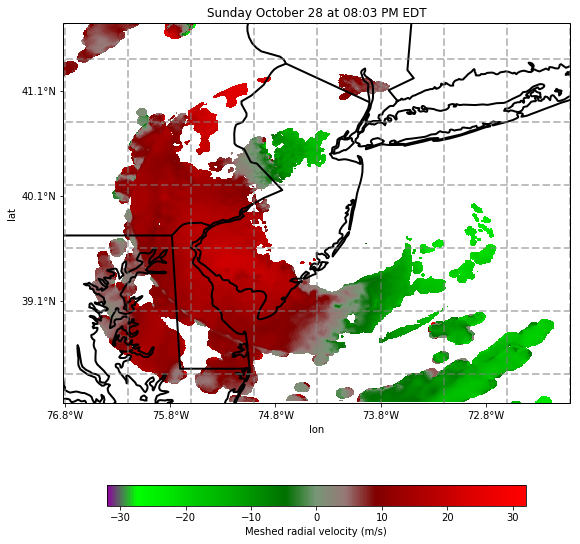

In [124]:
lat_lines = np.arange(np.around(this_ds.lat.min(), decimals=1), 
                      this_ds.lat.max(), 1)
lon_lines = np.arange(np.around(this_ds.lon.min(),decimals=1),
                      this_ds.lon.max(), 1)

fig = plt.figure(figsize=[15,10])

my_ax = plt.subplot(projection = ccrs.PlateCarree())

v_var = this_ds.velocity[0].sel(z=1000, method='nearest')
pc = v_var.where(z_var > 10).plot.pcolormesh(transform=ccrs.PlateCarree(), ax=my_ax,
                                                x='lon', y='lat', vmin=-32,
                                                    vmax=32, cmap=pyart.graph.cm.NWSVel,
                                                add_colorbar=False)

cb1 = plt.colorbar(mappable=pc, orientation='horizontal', shrink = 0.5)
cb1.set_label('Meshed radial velocity (m/s)')

my_ax.set_xticks(lon_lines, crs=ccrs.PlateCarree())
my_ax.set_yticks(lat_lines, crs=ccrs.PlateCarree())
lon_formatter = LongitudeFormatter(zero_direction_label=True)
lat_formatter = LatitudeFormatter()
my_ax.xaxis.set_major_formatter(lon_formatter)
my_ax.yaxis.set_major_formatter(lat_formatter)
gl = my_ax.gridlines(draw_labels=False,
                              linewidth=2, color='gray', alpha=0.5, linestyle='--')

political_boundaries = cartopy.feature.NaturalEarthFeature(category='cultural',
                               name='admin_0_boundary_lines_land',
                               scale='50m', facecolor='none')

states = cartopy.feature.NaturalEarthFeature(category='cultural',
                               name='admin_1_states_provinces_lines',
                               scale='50m', facecolor='none')

coast = cartopy.feature.NaturalEarthFeature(category='physical', scale='10m',
                            facecolor='none', name='coastline')

lake_50m = cartopy.feature.NaturalEarthFeature('physical', 'lakes', '10m',
                                        edgecolor='face',
                                        facecolor=cartopy.feature.COLORS['water'])

my_ax.add_feature(political_boundaries, linestyle='-', edgecolor='black')
my_ax.add_feature(states, linestyle='-', edgecolor='black',linewidth=2)
my_ax.add_feature(coast, linestyle='-', edgecolor='black',linewidth=2)
my_ax.add_feature(lake_50m, linestyle='-', edgecolor='black',linewidth=2,
                 zorder=0)



extent = [this_ds.lon.min(), this_ds.lon.max(), this_ds.lat.min(), this_ds.lat.max()]
my_ax.set_extent(extent)
plt.title(fancy_date_string)
#plt.savefig('/Users/scollis/funded_projects/precip_change/images/radar_'+strfmt+'.png')

In [160]:
dt = datetime.datetime(2012,10,29,0,0)
ds = make_radar_grid(dt, 'KDIX')
for i in range(15):
    dt += datetime.timedelta(minutes=10)
    print(dt)
    thisds = make_radar_grid(dt, 'KDIX')
    ds = xarray.concat((ds, thisds), dim='time')

<Key: noaa-nexrad-level2,2012/10/29/KDIX/KDIX20121029_000319_V06.gz>


/Users/scollis/anaconda/envs/pypower/lib/python3.6/site-packages/xarray/core/dtypes.py:23: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if np.issubdtype(dtype, float):


2012-10-29 00:10:00
<Key: noaa-nexrad-level2,2012/10/29/KDIX/KDIX20121029_000905_V06.gz>


/Users/scollis/anaconda/envs/pypower/lib/python3.6/site-packages/xarray/core/dtypes.py:23: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if np.issubdtype(dtype, float):


2012-10-29 00:20:00
<Key: noaa-nexrad-level2,2012/10/29/KDIX/KDIX20121029_002038_V06.gz>


/Users/scollis/anaconda/envs/pypower/lib/python3.6/site-packages/xarray/core/dtypes.py:23: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if np.issubdtype(dtype, float):


2012-10-29 00:30:00
<Key: noaa-nexrad-level2,2012/10/29/KDIX/KDIX20121029_003209_V06.gz>


/Users/scollis/anaconda/envs/pypower/lib/python3.6/site-packages/xarray/core/dtypes.py:23: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if np.issubdtype(dtype, float):


2012-10-29 00:40:00
<Key: noaa-nexrad-level2,2012/10/29/KDIX/KDIX20121029_003754_V06.gz>


/Users/scollis/anaconda/envs/pypower/lib/python3.6/site-packages/xarray/core/dtypes.py:23: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if np.issubdtype(dtype, float):


2012-10-29 00:50:00
<Key: noaa-nexrad-level2,2012/10/29/KDIX/KDIX20121029_004927_V06.gz>


/Users/scollis/anaconda/envs/pypower/lib/python3.6/site-packages/xarray/core/dtypes.py:23: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if np.issubdtype(dtype, float):


2012-10-29 01:00:00
<Key: noaa-nexrad-level2,2012/10/29/KDIX/KDIX20121029_010058_V06.gz>


/Users/scollis/anaconda/envs/pypower/lib/python3.6/site-packages/xarray/core/dtypes.py:23: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if np.issubdtype(dtype, float):


2012-10-29 01:10:00
<Key: noaa-nexrad-level2,2012/10/29/KDIX/KDIX20121029_011230_V06.gz>


/Users/scollis/anaconda/envs/pypower/lib/python3.6/site-packages/xarray/core/dtypes.py:23: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if np.issubdtype(dtype, float):


2012-10-29 01:20:00
<Key: noaa-nexrad-level2,2012/10/29/KDIX/KDIX20121029_011816_V06.gz>


/Users/scollis/anaconda/envs/pypower/lib/python3.6/site-packages/xarray/core/dtypes.py:23: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if np.issubdtype(dtype, float):


2012-10-29 01:30:00
<Key: noaa-nexrad-level2,2012/10/29/KDIX/KDIX20121029_012947_V06.gz>


/Users/scollis/anaconda/envs/pypower/lib/python3.6/site-packages/xarray/core/dtypes.py:23: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if np.issubdtype(dtype, float):


2012-10-29 01:40:00
<Key: noaa-nexrad-level2,2012/10/29/KDIX/KDIX20121029_014120_V06.gz>


/Users/scollis/anaconda/envs/pypower/lib/python3.6/site-packages/xarray/core/dtypes.py:23: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if np.issubdtype(dtype, float):


2012-10-29 01:50:00
<Key: noaa-nexrad-level2,2012/10/29/KDIX/KDIX20121029_015252_V06.gz>


/Users/scollis/anaconda/envs/pypower/lib/python3.6/site-packages/xarray/core/dtypes.py:23: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if np.issubdtype(dtype, float):


2012-10-29 02:00:00
<Key: noaa-nexrad-level2,2012/10/29/KDIX/KDIX20121029_020047_V06.gz>


/Users/scollis/anaconda/envs/pypower/lib/python3.6/site-packages/xarray/core/dtypes.py:23: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if np.issubdtype(dtype, float):


2012-10-29 02:10:00
<Key: noaa-nexrad-level2,2012/10/29/KDIX/KDIX20121029_021220_V06.gz>


/Users/scollis/anaconda/envs/pypower/lib/python3.6/site-packages/xarray/core/dtypes.py:23: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if np.issubdtype(dtype, float):


2012-10-29 02:20:00
<Key: noaa-nexrad-level2,2012/10/29/KDIX/KDIX20121029_021806_V06.gz>


/Users/scollis/anaconda/envs/pypower/lib/python3.6/site-packages/xarray/core/dtypes.py:23: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if np.issubdtype(dtype, float):


2012-10-29 02:30:00
<Key: noaa-nexrad-level2,2012/10/29/KDIX/KDIX20121029_022937_V06.gz>


/Users/scollis/anaconda/envs/pypower/lib/python3.6/site-packages/xarray/core/dtypes.py:23: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if np.issubdtype(dtype, float):


In [161]:
ds

<xarray.Dataset>
Dimensions:                    (time: 16, x: 801, y: 801, z: 1)
Coordinates:
  * z                          (z) float64 1e+03
    lat                        (y, x) float64 38.13 38.13 38.13 38.13 38.13 ...
    lon                        (y, x) float64 -76.7 -76.69 -76.69 -76.68 ...
  * y                          (y) float64 38.13 38.13 38.13 38.14 38.14 ...
  * x                          (x) float64 -76.7 -76.69 -76.69 -76.68 -76.67 ...
  * time                       (time) datetime64[ns] 2012-10-29T00:03:19.196000 ...
Data variables:
    differential_phase         (time, z, y, x) float32 62.808247 62.08878 ...
    differential_reflectivity  (time, z, y, x) float32 0.69841987 0.5406287 ...
    velocity                   (time, z, y, x) float32 nan nan nan nan nan ...
    reflectivity               (time, z, y, x) float32 15.162318 15.562643 ...
    cross_correlation_ratio    (time, z, y, x) float32 1.0055563 0.9972958 ...
    spectrum_width             (time, z, y, x) 

In [162]:
ssds = ds.sel(x=slice(-75.8, -75.5), y=slice(40.0, 40.3), z=1000.0)


/Users/scollis/anaconda/envs/pypower/lib/python3.6/site-packages/xarray/core/dtypes.py:23: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if np.issubdtype(dtype, float):


Text(0.5,1,'Sunday October 28 at 08:03 PM EDT')

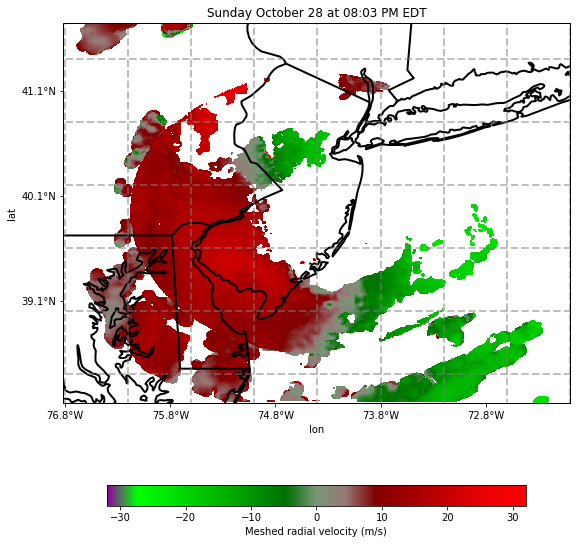

In [148]:
this_ds = ds.sel(time=datetime.datetime(2012,10,29,0,10), method='nearest')
lat_lines = np.arange(np.around(this_ds.lat.min(), decimals=1), 
                      this_ds.lat.max(), 1)
lon_lines = np.arange(np.around(this_ds.lon.min(),decimals=1),
                      this_ds.lon.max(), 1)

fig = plt.figure(figsize=[15,10])

my_ax = plt.subplot(projection = ccrs.PlateCarree())

v_var = this_ds.velocity.sel(z=1000, method='nearest')
pc = v_var.where(z_var > 10).plot.pcolormesh(transform=ccrs.PlateCarree(), ax=my_ax,
                                                x='lon', y='lat', vmin=-32,
                                                    vmax=32, cmap=pyart.graph.cm.NWSVel,
                                                add_colorbar=False)

cb1 = plt.colorbar(mappable=pc, orientation='horizontal', shrink = 0.5)
cb1.set_label('Meshed radial velocity (m/s)')

my_ax.set_xticks(lon_lines, crs=ccrs.PlateCarree())
my_ax.set_yticks(lat_lines, crs=ccrs.PlateCarree())
lon_formatter = LongitudeFormatter(zero_direction_label=True)
lat_formatter = LatitudeFormatter()
my_ax.xaxis.set_major_formatter(lon_formatter)
my_ax.yaxis.set_major_formatter(lat_formatter)
gl = my_ax.gridlines(draw_labels=False,
                              linewidth=2, color='gray', alpha=0.5, linestyle='--')

political_boundaries = cartopy.feature.NaturalEarthFeature(category='cultural',
                               name='admin_0_boundary_lines_land',
                               scale='50m', facecolor='none')

states = cartopy.feature.NaturalEarthFeature(category='cultural',
                               name='admin_1_states_provinces_lines',
                               scale='50m', facecolor='none')

coast = cartopy.feature.NaturalEarthFeature(category='physical', scale='10m',
                            facecolor='none', name='coastline')

lake_50m = cartopy.feature.NaturalEarthFeature('physical', 'lakes', '10m',
                                        edgecolor='face',
                                        facecolor=cartopy.feature.COLORS['water'])

my_ax.add_feature(political_boundaries, linestyle='-', edgecolor='black')
my_ax.add_feature(states, linestyle='-', edgecolor='black',linewidth=2)
my_ax.add_feature(coast, linestyle='-', edgecolor='black',linewidth=2)
my_ax.add_feature(lake_50m, linestyle='-', edgecolor='black',linewidth=2,
                 zorder=0)



extent = [this_ds.lon.min(), this_ds.lon.max(), this_ds.lat.min(), this_ds.lat.max()]
my_ax.set_extent(extent)
plt.title(fancy_date_string)
#plt.savefig('/Users/scollis/funded_projects/precip_change/images/radar_'+strfmt+'.png')

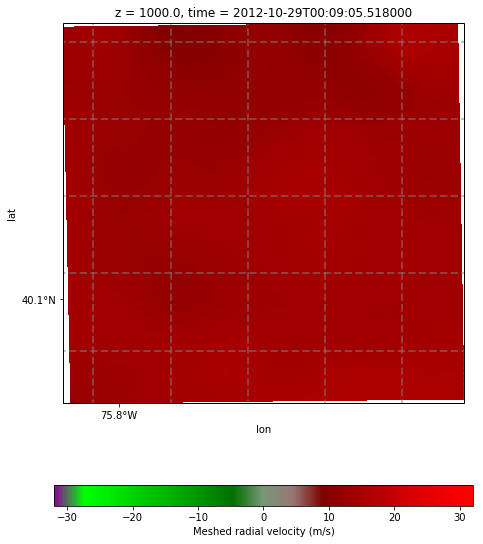

In [157]:

fig = plt.figure(figsize=[15,10])

my_ax = plt.subplot(projection = ccrs.PlateCarree())

tsme = ssds.sel(time=datetime.datetime(2012,10,29,0,10), method='nearest')
pc = tsme.velocity.plot.pcolormesh(transform=ccrs.PlateCarree(),
                                                x='lon', y='lat', vmin=-32,
                                                    vmax=32, cmap=pyart.graph.cm.NWSVel,
                                                add_colorbar=False)
cb1 = plt.colorbar(mappable=pc, orientation='horizontal', shrink = 0.5)
cb1.set_label('Meshed radial velocity (m/s)')

my_ax.set_xticks(lon_lines, crs=ccrs.PlateCarree())
my_ax.set_yticks(lat_lines, crs=ccrs.PlateCarree())
lon_formatter = LongitudeFormatter(zero_direction_label=True)
lat_formatter = LatitudeFormatter()
my_ax.xaxis.set_major_formatter(lon_formatter)
my_ax.yaxis.set_major_formatter(lat_formatter)
gl = my_ax.gridlines(draw_labels=False,
                              linewidth=2, color='gray', alpha=0.5, linestyle='--')

political_boundaries = cartopy.feature.NaturalEarthFeature(category='cultural',
                               name='admin_0_boundary_lines_land',
                               scale='50m', facecolor='none')

states = cartopy.feature.NaturalEarthFeature(category='cultural',
                               name='admin_1_states_provinces_lines',
                               scale='50m', facecolor='none')

coast = cartopy.feature.NaturalEarthFeature(category='physical', scale='10m',
                            facecolor='none', name='coastline')

lake_50m = cartopy.feature.NaturalEarthFeature('physical', 'lakes', '10m',
                                        edgecolor='face',
                                        facecolor=cartopy.feature.COLORS['water'])

my_ax.add_feature(political_boundaries, linestyle='-', edgecolor='black')
my_ax.add_feature(states, linestyle='-', edgecolor='black',linewidth=2)
my_ax.add_feature(coast, linestyle='-', edgecolor='black',linewidth=2)
my_ax.add_feature(lake_50m, linestyle='-', edgecolor='black',linewidth=2,
                 zorder=0)



extent = [tsme.lon.min(), tsme.lon.max(), tsme.lat.min(), tsme.lat.max()]
my_ax.set_extent(extent)

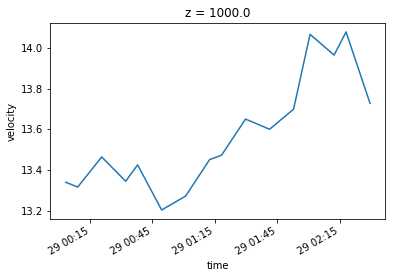

In [163]:
ssds.velocity.mean(dim=('x','y'), skipna=True).plot()

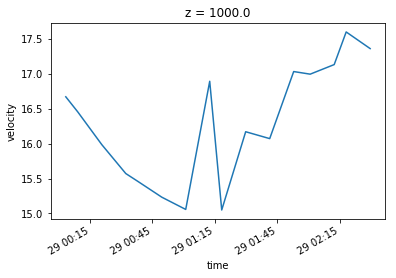

In [164]:
ssds.velocity.max(dim=('x','y'), skipna=True).plot()

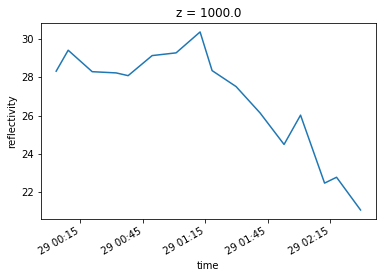

In [165]:
ssds.reflectivity.max(dim=('x','y'), skipna=True).plot()

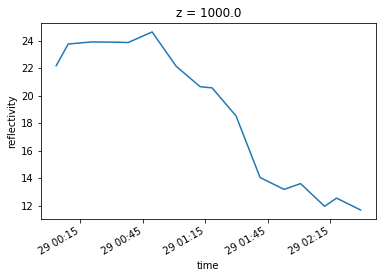

In [166]:
ssds.reflectivity.mean(dim=('x','y'), skipna=True).plot()